In [1]:
# Hyperparameters for simulation
nparticles = 100  # Number of particles
nframes = 10  # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 10000        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50


In [2]:
%reload_ext autoreload
%autoreload 2
from helpers import *
#from modelsUtils import *
#from simpleCNNModel import *
#from ResNetModel import *
#from paperCNN import *
import os.path

#device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")


In [3]:
def compute_centroid_positions(trajectory, nframes, nposframe):
    """
    Computes the centroid positions for each frame in the trajectory.
    
    Parameters:
    - trajectory (ndarray): Array of shape (num_steps, 2), positions over time.
    - nframes (int): Number of frames.
    - nposframe (int): Number of positions per frame.
    
    Returns:
    - centroids (ndarray): Array of shape (nframes, 2), centroid positions for each frame.
    """
    centroids = np.zeros((nframes, 2))
    for k in range(nframes):
        start = k * nposframe
        end = (k + 1) * nposframe
        segment = trajectory[start:end, :]
        centroid = np.mean(segment, axis=0)
        centroids[k, :] = centroid
    return centroids

def mean_square_displacement_from_centroids(centroids):
    """
    Computes the MSD from centroid positions over frames.
    
    Parameters:
    - centroids (ndarray): Array of shape (nframes, 2)
    
    Returns:
    - msd (ndarray): MSD values for time lags.
    """
    nframes = centroids.shape[0]
    msd = np.zeros(nframes)
    for tao in range(1, nframes):  # start from tao=1
        displacements = np.sum((centroids[tao:] - centroids[:nframes-tao])**2, axis=1)
        msd[tao] = np.mean(displacements)
    return msd

def estimateDfromCentroids(trajectory, nframes, nposframe, dt):
    centroids = compute_centroid_positions(trajectory, nframes, nposframe)
    centroids_time = np.arange(nframes) * dt  # time points for centroids
    msd = mean_square_displacement_from_centroids(centroids)
    D_coarse = estimateDfromMSD(msd, centroids_time)
    return D_coarse


In [4]:
def generateImagesAndEstimateDFromTrajs(
    trajectories, nparticles, nframes, npixel, factor_hr, nposframe, D, dt,
    fwhm_psf, pixelsize, flux, background, poisson_noise, gaussian_noise, normalizeValue=-1):
    """
    Generates images and estimates both fine and coarse diffusion coefficients (D) for each particle.
    
    Parameters:
    - trajectories (ndarray): Array of shape (nparticles, num_steps, 2)
    - Other parameters as before
    
    Returns:
    - image_array (ndarray): Array of shape (nparticles, nframes, npixel, npixel)
    - D_estimates (ndarray): Array of size (nparticles), estimated D from full trajectory
    - D_estimates_coarse (ndarray): Array of size (nparticles), estimated D from centroids
    """
    image_array = np.zeros((nparticles, nframes, npixel, npixel))
    D_estimates = np.zeros(nparticles)
    D_estimates_coarse = np.zeros(nparticles)
    time_range = np.arange(nframes * nposframe) * dt / nposframe

    for p in range(nparticles):
        trajectory = trajectories[p]
        frame_hr = np.zeros((nframes, npixel * factor_hr, npixel * factor_hr))
        frame_noisy = np.zeros((nframes, npixel, npixel))

        for k in range(nframes):
            start = k * nposframe
            end = (k + 1) * nposframe
            trajectory_segment = trajectory[start:end, :]
            xtraj = trajectory_segment[:, 0]
            ytraj = trajectory_segment[:, 1]

            # Generate frames
            for pos in range(nposframe):
                frame_spot = gaussian_2d(
                    xtraj[pos], ytraj[pos], 2.35 * fwhm_psf / pixelsize,
                    npixel * factor_hr, flux
                )
                frame_hr[k] += frame_spot

            # Downsample and add noise
            frame_lr = block_reduce(frame_hr[k], block_size=factor_hr, func=np.mean)
            frame_noisy[k] = add_noise_background(
                frame_lr, background, poisson_noise, gaussian_noise, normalizeValue
            )
        # Store the noisy images
        image_array[p] = frame_noisy

        # Estimate D from the full trajectory
        msd_full = mean_square_displacement(trajectory)
        D_estimates[p] = estimateDfromMSD(msd_full, time_range)

        # Estimate D from centroids (coarse)
        D_estimates_coarse[p] = estimateDfromCentroids(trajectory, nframes, nposframe, dt)

    return image_array, D_estimates, D_estimates_coarse


In [5]:
trajectories = brownian_motion(nparticles, nframes, nposframe, DGen, dt)

# Generate images and estimate D
images, D_estimates_fine, D_estimates_coarse = generateImagesAndEstimateDFromTrajs(
    trajectories, nparticles, nframes, npixel=64, factor_hr=2, nposframe=nposframe, D=DGen ,dt=dt,
    fwhm_psf=300, pixelsize=100, flux=1000, background=10, poisson_noise=1, gaussian_noise=2)


# Print estimated D values
for p in range(nparticles):
    print(f"Particle {p}: Fine D = {D_estimates_fine[p]:.4f}, Coarse D = {D_estimates_coarse[p]:.4f}")


Particle 0: Fine D = 6488.4003, Coarse D = 5362.2861
Particle 1: Fine D = 7481.2085, Coarse D = 7701.2354
Particle 2: Fine D = 4644.9701, Coarse D = 4519.7328
Particle 3: Fine D = 13348.5359, Coarse D = 12380.1630
Particle 4: Fine D = 12842.8275, Coarse D = 11338.9037
Particle 5: Fine D = 8935.0847, Coarse D = 9001.9413
Particle 6: Fine D = 8031.8715, Coarse D = 6867.2179
Particle 7: Fine D = 10325.8960, Coarse D = 9729.0749
Particle 8: Fine D = 4618.0744, Coarse D = 4284.4773
Particle 9: Fine D = 14148.1361, Coarse D = 12730.9270
Particle 10: Fine D = 8889.4612, Coarse D = 8688.5466
Particle 11: Fine D = 18641.2638, Coarse D = 17111.5562
Particle 12: Fine D = 15713.8556, Coarse D = 13881.0187
Particle 13: Fine D = 6980.9760, Coarse D = 6801.6716
Particle 14: Fine D = 31033.5034, Coarse D = 29906.6805
Particle 15: Fine D = 3460.2808, Coarse D = 2959.2136
Particle 16: Fine D = 9021.2323, Coarse D = 8603.5058
Particle 17: Fine D = 4505.8352, Coarse D = 4529.9844
Particle 18: Fine D = 249

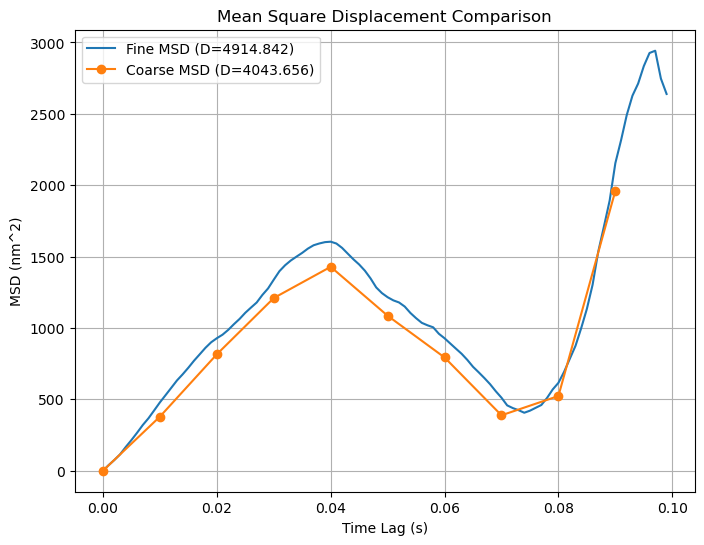

In [6]:
import matplotlib.pyplot as plt

def plot_MSDs(msd_fine, msd_coarse, time_range_fine, time_range_coarse, D_estimate_fine, D_estimate_coarse):
    plt.figure(figsize=(8, 6))
    plt.plot(time_range_fine, msd_fine, label=f'Fine MSD (D={D_estimate_fine:.3f})')
    plt.plot(time_range_coarse, msd_coarse, label=f'Coarse MSD (D={D_estimate_coarse:.3f})', marker='o')
    plt.xlabel('Time Lag (s)')
    plt.ylabel('MSD (nm^2)')
    plt.title('Mean Square Displacement Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for one particle
p = 19
trajectory = trajectories[p]
msd_full = mean_square_displacement(trajectory)
time_range_full = np.arange(nframes * nposframe) * dt / nposframe
D_estimate_fine = D_estimates_fine[p]

centroids = compute_centroid_positions(trajectory, nframes, nposframe)
msd_centroids = mean_square_displacement_from_centroids(centroids)
time_range_centroids = np.arange(nframes) * dt
D_estimate_coarse = D_estimates_coarse[p]

plot_MSDs(msd_full, msd_centroids, time_range_full, time_range_centroids, D_estimate_fine, D_estimate_coarse)


In [7]:
print("Length of time_range_coarse:", len(time_range_centroids))
print("Length of msd_coarse:", len(msd_centroids))


Length of time_range_coarse: 10
Length of msd_coarse: 10


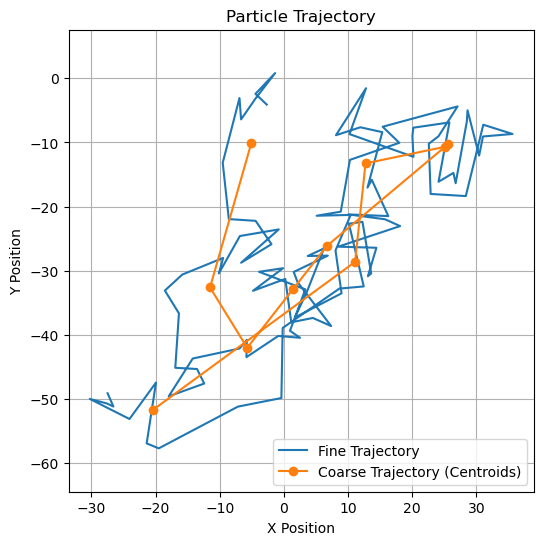

In [8]:
plt.figure(figsize=(6, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], label='Fine Trajectory')
plt.plot(centroids[:, 0], centroids[:, 1], 'o-', label='Coarse Trajectory (Centroids)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Particle Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()